# GradientBoosting

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
#np.warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score, precision_score, accuracy_score,\
                            recall_score, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

## Preprocesado

In [2]:
#import importlib, sys
from Preprocessing import *

In [9]:
df = preprod_tp1(df_data, df_decision)
df = replace_nulls_edad(df, 'media')
df.head()

,tipo_de_sala,id_usuario,genero,edad,amigos,parientes,precio_ticket,nombre_sede,cant_acompañantes,volveria
0,4d,117,hombre,73.5,0,0,1,fiumark_quilmes,0,0
1,4d,658,mujer,35.0,1,1,2,fiumark_quilmes,2,0
2,normal,794,hombre,32.7,0,0,3,fiumark_chacarita,0,0
3,4d,455,hombre,32.7,0,0,1,fiumark_palermo,0,0
4,4d,173,mujer,4.0,1,1,2,fiumark_palermo,2,1


In [10]:
df = encodear_atributos_categoricos(df)
df.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes,volveria
0,0,0,1,117,0,1,73.5,0,0,1,0,0,1,0,0
1,0,0,1,658,1,0,35.0,1,1,2,0,0,1,2,0
2,0,1,0,794,0,1,32.7,0,0,3,0,1,0,0,0
3,0,0,1,455,0,1,32.7,0,0,1,0,1,1,0,0
4,0,0,1,173,1,0,4.0,1,1,2,0,1,1,2,1


## Entrenamiento

In [11]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]

In [12]:
X.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes
0,0,0,1,117,0,1,73.5,0,0,1,0,0,1,0
1,0,0,1,658,1,0,35.0,1,1,2,0,0,1,2
2,0,1,0,794,0,1,32.7,0,0,3,0,1,0,0
3,0,0,1,455,0,1,32.7,0,0,1,0,1,1,0
4,0,0,1,173,1,0,4.0,1,1,2,0,1,1,2


In [13]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: volveria, dtype: int64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117)

## Random Search

In [27]:
params = {'min_samples_split': np.arange(1, 16), 
          'max_depth': np.arange(1, 35),
          'n_estimators': np.arange(75, 125),
          'learning_rate': [0.1, 0.2, 0.4, 0.7],
          'criterion': ['friedman_mse', 'mse', 'mae'],
          'loss': ['deviance', 'exponential'],
         }

model_bagging = GradientBoostingClassifier(random_state=117)

rgscv = RandomizedSearchCV(
    model_bagging, params, n_iter=60, scoring='roc_auc', cv=5, return_train_score=True
).fit(X_train, y_train)

In [28]:
print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.8495739920220045
Best params {'n_estimators': 98, 'min_samples_split': 9, 'max_depth': 6, 'loss': 'exponential', 'learning_rate': 0.2, 'criterion': 'mse'}


## Metricas

### Accuracy

In [29]:
accuracy_score(y_test, rgscv.predict(X_test))

0.8159203980099502

### Precision

In [30]:
precision_score(y_test, rgscv.predict(X_test))

0.7846153846153846

### Recall

In [31]:
recall_score(y_test, rgscv.predict(X_test), pos_label=0)

0.889763779527559

### F1-Score

In [32]:
f1_score(y_test, rgscv.predict(X_test))

0.7338129496402878

### Matriz de confusion

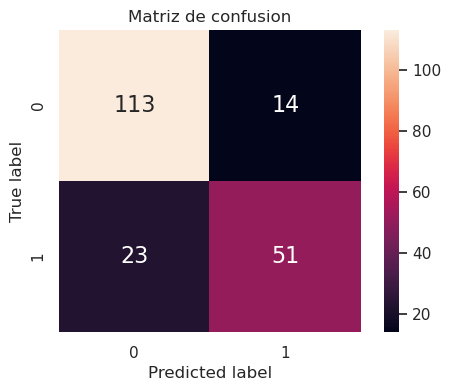

In [33]:
def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusion")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


plot_confusion_matrix(y_test, rgscv.predict(X_test))

### Curva ARUC ROC

In [35]:
roc_auc_score(y_test, rgscv.predict_proba(X_test)[:,1])

0.8344328580549053

## Test holdout

In [42]:
# TODO: test holdout